In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize
import pymc3 as pm
from pymc3.ode import DifferentialEquation
from functools import partial
import scipy.stats as st

In [2]:
plt.rcParams["figure.figsize"] = (14,6)

In [3]:
data = pd.read_csv("../data/obs.csv", parse_dates=["date"])
data

,date,I,R,D,C
0,2020-01-22,4,0,0,4
1,2020-01-23,6,0,0,6
2,2020-01-24,12,0,0,12
3,2020-01-25,20,0,0,20
4,2020-01-26,29,0,0,29
...,...,...,...,...,...
135,2020-06-05,0,1015,4,1019
136,2020-06-06,0,1015,4,1019
137,2020-06-07,0,1015,4,1019
138,2020-06-08,0,1015,4,1019


In [4]:
data = data.drop(columns="C")
data = data.set_index("date")

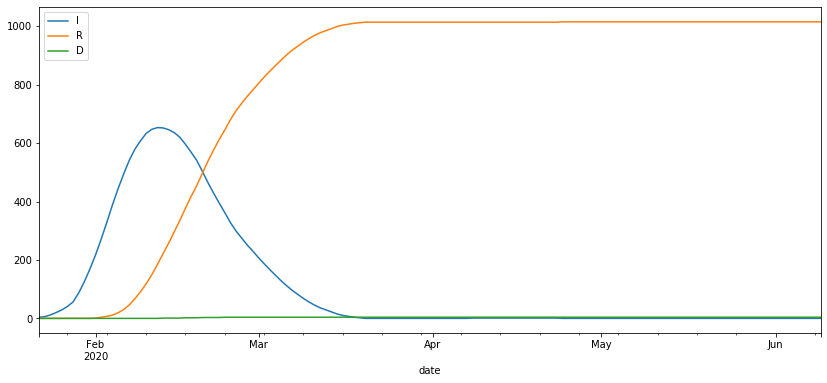

In [5]:
data.plot();

In [6]:
data["R"] = data["R"] + data["D"]
data = data.drop(columns=["D"])

In [7]:
train = data[:"2020-04-01"].copy()
test = data["2020-04-02":].copy()

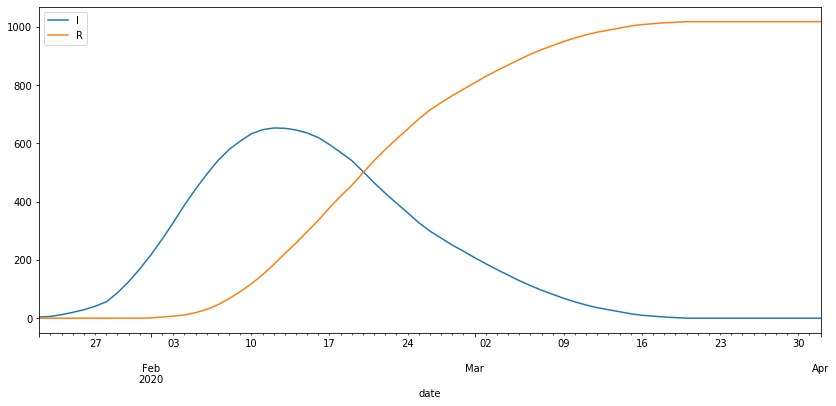

In [8]:
train.plot();

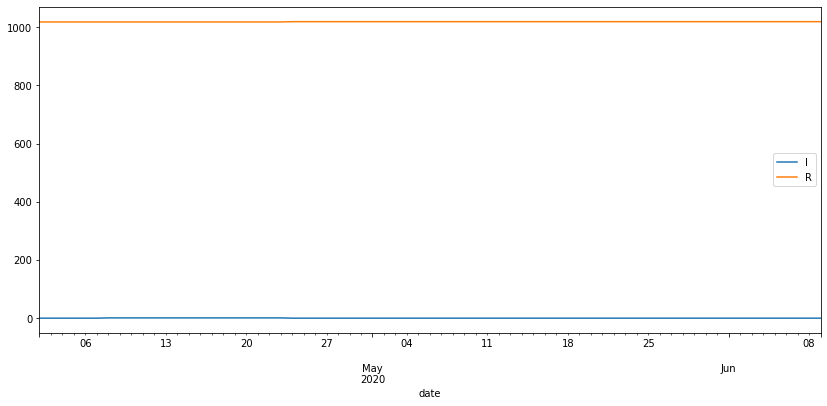

In [9]:
test.plot();

In [50]:
def SIR(y, t, p):
    N = p[0]
    beta = p[1]
    gamma = p[2]
    I = y[0] 
    R = y[1]
    
    S = N - I - R
    dI = beta * S * I / N - gamma * I
    dR = gamma * I
    return dI, dR 

In [51]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0, len(train), 1),
    n_states=2, 
    n_theta=3,
    t0=0,
)

In [54]:
y0 = train.head(1).iloc[0,:]
y0

I    4
R    0
Name: 2020-01-22 00:00:00, dtype: int64

In [47]:
#output = solve_ivp(SIR, t_span=(0,len(train)), y0=(4, 0), t_eval=np.arange(0,len(train),1), args=((1074, 0.45, 1/17),) )

In [58]:
with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    pop = pm.Bound(pm.Normal, lower=0)('pop', 1000, 100)
    beta = pm.Bound(pm.Normal, lower=0)('beta', 0.5, 0.5)
    gamma = pm.Bound(pm.Normal, lower=0)('gamma', 1/17, 0.1)

    sir_curves = sir_model(y0=y0, theta=[pop, beta, gamma])

    Y = pm.Normal('Y', mu=sir_curves, sd=sigma, observed=train.to_numpy())

    #prior = pm.sample_prior_predictive()
    trace = pm.sample(1000, tune=100, target_accept=0.9, cores=1)
    #posterior_predictive = pm.sample_posterior_predictive(trace)

    #data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, beta, pop, sigma]
Sampling chain 0, 0 divergences:  98%|██████████████████████████████████████████ | 1076/1100 [3:27:26<04:37, 11.57s/it]


SystemError: <built-in method reshape of numpy.ndarray object at 0x0000014B5DBBD760> returned a result with an error set
Apply node that caused the error: for{cpu,scan_fn&scan_fn}(TensorConstant{2}, TensorConstant{[0 1]}, TensorConstant{2}, TensorConstant{2}, MakeVector{dtype='float64'}.0, Subtensor{int64}.0, Alloc.0, Subtensor{int64}.0, Elemwise{sqr,no_inplace}.0, Elemwise{Composite{((i0 - i1) - i2)}}.0, Subtensor{int64}.0, Elemwise{mul,no_inplace}.0, Alloc.0, Alloc.0, Subtensor{int64}.0, Elemwise{mul,no_inplace}.0)
Toposort index: 28
Inputs types: [TensorType(int64, scalar), TensorType(int64, vector), TensorType(int64, scalar), TensorType(int64, scalar), TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, scalar)]
Inputs shapes: [(), (2,), (), (), (2,), (), (3,), (), (), (), (), (), (5,), (2,), (), ()]
Inputs strides: [(), (8,), (), (), (8,), (), (8,), (), (), (), (), (), (8,), (8,), (), ()]
Inputs values: [array(2, dtype=int64), array([0, 1], dtype=int64), array(2, dtype=int64), array(2, dtype=int64), array([-17.70765973,   1.3605388 ]), array(3.44418117), array([0., 0., 0.]), array(0.73947236), array(0.54681937), array(-2.74409136), array(1.27902391), array(-12.08824406), array([0., 0., 0., 0., 0.]), array([0., 0.]), array(0.39502533), array(-3.50975847)]
Outputs clients: [[Gemm{inplace}(for{cpu,scan_fn&scan_fn}.0, TensorConstant{1.0}, for{cpu,scan_fn&scan_fn}.1, Reshape{2}.0, TensorConstant{1.0})], [Gemm{inplace}(for{cpu,scan_fn&scan_fn}.0, TensorConstant{1.0}, for{cpu,scan_fn&scan_fn}.1, Reshape{2}.0, TensorConstant{1.0})]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: DifferentialEquation{func=<function SIR at 0x0000014B59368168>, times=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70), n_states=2, n_theta=3, t0=0}(TensorConstant{[4. 0.]}, MakeVector{dtype='float64'}.0)
Toposort index: 29
Inputs types: [TensorType(float64, vector), TensorType(float64, vector)]
Inputs shapes: [(2,), (3,)]
Inputs strides: [(8,), (8,)]
Inputs values: [array([4., 0.]), array([0.73947236, 1.27902391, 0.39502533])]
Outputs clients: [[Elemwise{Composite{Switch(i0, (i1 * i2 * (i3 - i4)), i5)}}(Elemwise{Composite{Cast{int8}(GT(i0, i1))}}.0, Subtensor{::, ::, int64}.0, InplaceDimShuffle{x,0}.0, TensorConstant{[[4.000e+0...018e+03]]}, DifferentialEquation{func=<function SIR at 0x0000014B59368168>, times=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70), n_states=2, n_theta=3, t0=0}.0, TensorConstant{(1, 1) of 0}), Elemwise{Composite{Switch(i0, (i1 * i2 * (i3 - i4)), i5)}}(Elemwise{Composite{Cast{int8}(GT(i0, i1))}}.0, Subtensor{::, ::, int64}.0, InplaceDimShuffle{x,0}.0, TensorConstant{[[4.000e+0...018e+03]]}, DifferentialEquation{func=<function SIR at 0x0000014B59368168>, times=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70), n_states=2, n_theta=3, t0=0}.0, TensorConstant{(1, 1) of 0}), Elemwise{Composite{sqr((i0 - i1))}}[(0, 1)](TensorConstant{[[4.000e+0...018e+03]]}, DifferentialEquation{func=<function SIR at 0x0000014B59368168>, times=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70), n_states=2, n_theta=3, t0=0}.0), Elemwise{Composite{Switch(i0, (i1 * i2 * (i3 - i4)), i5)}}[(0, 1)](Elemwise{Composite{Cast{int8}(GT(i0, i1))}}.0, Subtensor{::, ::, int64}.0, InplaceDimShuffle{x,0}.0, TensorConstant{[[4.000e+0...018e+03]]}, DifferentialEquation{func=<function SIR at 0x0000014B59368168>, times=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70), n_states=2, n_theta=3, t0=0}.0, TensorConstant{(1, 1) of 0})], [Subtensor{::, ::, int64}(DifferentialEquation{func=<function SIR at 0x0000014B59368168>, times=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70), n_states=2, n_theta=3, t0=0}.1, Constant{4}), Subtensor{::, ::, int64}(DifferentialEquation{func=<function SIR at 0x0000014B59368168>, times=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70), n_states=2, n_theta=3, t0=0}.1, Constant{3}), Subtensor{::, ::, int64}(DifferentialEquation{func=<function SIR at 0x0000014B59368168>, times=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70), n_states=2, n_theta=3, t0=0}.1, Constant{2})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-58-57d91deb8cdc>", line 9, in <module>
    sir_curves = sir_model(y0=y0, theta=[pop, beta, gamma])
  File "C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\pymc3\ode\ode.py", line 134, in __call__
    states, sens = super(theano.Op, self).__call__(y0, theta, **kwargs)
  File "C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\theano\gof\op.py", line 615, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "C:\Users\ariel\Anaconda3\envs\ml\lib\site-packages\pymc3\ode\ode.py", line 112, in make_node
    states = self._otypes[0]()

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.